# Car Review Classification

# Imports

In [351]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE, BorderlineSMOTE


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Functions

In [360]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def create_column_transformer( numeric_features, categorical_features):
  
  numeric_features_columns = numeric_features.columns
  numeric_transformer = Pipeline(
      steps=[("scaler", StandardScaler()), ("power_tranformer",PowerTransformer())]
  )

  categorical_features_columns = categorical_features.columns
  categorical_transformer = Pipeline(
      steps=[
          ('imputer', SimpleImputer(strategy='most_frequent')),
          ("encoder", OneHotEncoder(handle_unknown="ignore")),
      ]
  )
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_transformer, numeric_features_columns),
          ("cat", categorical_transformer, categorical_features_columns),
      ]
  )
  
  return preprocessor

def create_pipeline(preprocessor, model, metric_name=None, kbest=None):
    """
    - This function creates our pipeline.
    - Takes a preprocessor which transforms cat/numeric features
    - Can accept a metric
    - Model to test

    Returns:
        Pipeline
    """
    
    steps = [("preprocessor", preprocessor), ("model", model)]
    if kbest:
        steps.insert(1, ((metric_name,kbest)))
    return Pipeline(steps=steps) 

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(accuracy_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def create_model_performance_visual(df):
    fig, ax = plt.subplots(figsize=(10, 6)) 

    df.plot.bar(x='Model', y=['Validation Accuracy', 'Test Accuracy'], ax=ax)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Model Performance Comparison", fontsize=16)

    ax.legend(["Validation Accuracy", "Test Accuracy"])
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, 
                            preprocessor, sampled=None):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        if not sampled:
            pipeline = create_pipeline(preprocessor, model)
        else:
            pipeline = model
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def create_confusion_matrix(model_name:str, y_test:pd.Series, y_test_pred:pd.Series):
    """
    This function displays a classificaiton report
    & a Confusion Matrix

    Args:
        model_name (str): _description_
        y_test (pd.Series): _description_
        y_test_pred (pd.Series): _description_
    """
    
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

def get_over_sampling_methods(X, y, name, preprocessor):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  sampling_model = sampling_models[name]
  
  pipeline = create_pipeline(preprocessor, sampling_model)
  X_res, y_res = pipeline.fit_resample(X, y)
  return (X_res, y_res)

def test_model_predictions(names, models, X, y):
    
    model_performance = []
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    for i in range(len(models)):
        model, name = models[i],names[i]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        create_confusion_matrix(name, y_test, y_test_pred)
            
        model_performance.append({
                "Model": name,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
        })
    model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)
    create_model_performance_visual(model_performance_df)

# EDA Analysis

In [318]:
df = pd.read_csv("/Users/maukanmir/Downloads/cars.csv")
df

,car brand,car model,manufacturing year,car full name,url,strengths,weaknesses,rating,full description,word count for full description,...,horsepower,torque,drive_system,transmission,length,height,overall width with mirrors,overall width without mirrors,curb weight,"cargo capacity, all seats In place"
0,jeep,jeep wrangler,1998,jeep wrangler 1998,https://www.edmunds.com/jeep/wrangler/1998/rev...,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",4.3 out of 5 stars,Jeep has improved off-road capability by incre...,427,...,"120 hp @ 5,400 rpm","140 lb-ft @ 3,500 rpm",four wheel drive,5-speed manual,147.7 in.,69.6 in.,NaN,66.7 in.,"3,045 lbs.",11.1 cu.ft.
1,toyota,toyota 4runner,2005,toyota 4runner 2005,https://www.edmunds.com/toyota/4runner/2005/re...,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...",4.8 out of 5 stars,The base V6 now comes with a five-speed automa...,110,...,"245 hp @ 5,200 rpm","282 lb-ft @ 3,800 rpm",rear wheel drive,5-speed automatic,189.0 in.,68.5 in.,NaN,73.8 in.,"4,045 lbs.",36.6 cu.ft.
2,toyota,toyota tundra,2002,toyota tundra 2002,https://www.edmunds.com/toyota/tundra/2002/rev...,"['Silky V8, Toyota build quality, less-than-fu...",['Lacks wide range of choice offered by domest...,4.7 out of 5 stars,"SR5 models have new 16-inch wheels, and a limi...",534,...,"190 hp @ 4,800 rpm","220 lb-ft @ 3,600 rpm",rear wheel drive,5-speed manual,217.5 in.,70.5 in.,NaN,75.2 in.,"3,795 lbs.",NaN
3,toyota,toyota tacoma,1998,toyota tacoma 1998,https://www.edmunds.com/toyota/tacoma/1998/rev...,"['Unique styling, Toyota reliability, and powe...",['Extended cab models lack a third door and th...,4.6 out of 5 stars,The 1998 four-wheel-drive Tacomas receive fres...,592,...,"142 hp @ 5,000 rpm","160 lb-ft @ 4,000 rpm",rear wheel drive,5-speed manual,203.1 in.,62.0 in.,NaN,66.5 in.,NaN,NaN
4,ford,ford ranger,1990,ford ranger 1990,https://www.edmunds.com/ford/ranger/1990/review/,empty,empty,4.1 out of 5 stars,No changes for the Ford Ranger.,6,...,"100 hp @ 4,600 rpm","133 lb-ft @ 2,600 rpm",four wheel drive,5-speed manual,188.5 in.,63.6 in.,NaN,66.8 in.,"3,168 lbs.",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,jeep,jeep renegade,2023,jeep renegade 2023,https://www.edmunds.com/jeep/renegade/,"[""Trailhawk model's excellent off-road capabil...",['High price when optioned with nice-to-have f...,NaN,The 2023 Jeep Renegade is a versatile subcomp...,1065,...,"177 hp @ 5,750 rpm","210 lb-ft @ 1,750 rpm",four wheel drive,9-speed automatic,166.6 in.,66.5 in.,79.6 in.,74.2 in.,"3,210 lbs.",18.5 cu.ft.
3459,bmw,bmw alpina-b7,2022,bmw alpina-b7 2022,https://www.edmunds.com/bmw/alpina-b7/,"['Smooth yet ridiculously quick acceleration',...","['Unintuitive gesture controls', ""Rear seats d...",NaN,High-performance M models have proliferated t...,1210,...,"600 hp @ 5,500 rpm","590 lb-ft @ 2,000 rpm",all wheel drive,8-speed shiftable automatic,207.4 in.,58.7 in.,85.4 in.,74.9 in.,"4,866 lbs.",18.2 cu.ft.
3460,chevrolet,chevrolet colorado,2022,chevrolet colorado 2022,https://www.edmunds.com/chevrolet/colorado/,['Gasoline V6 and diesel four-cylinder engines...,['Front seats can feel confining for larger pe...,NaN,"After a handful of minor changes last year, t...",1219,...,"237 hp @ 5,600 rpm","260 lb-ft @ 1,200 rpm",rear wheel drive,8-speed shiftable automatic,213.0 in.,78.8 in.,84.4 in.,74.9 in.,"4,270 lbs.",NaN
3461,bmw,bmw 4-series,2023,bmw 4-series 2023,https://www.edmunds.com/bmw/4-series/2023/m440i/,"['Powerful and fuel-efficient engines', ""Sport...",['Flat hood makes it hard to place the front e...,NaN,The 4 Series is based on the 3 Series sedan b...,1318,...,"382 hp @ 5,800 rpm","369 lb-ft @ 1,800 rpm",rear wheel drive,8-speed shiftable automatic,188.0 in.,54.6 in.,81.9 in.,72.9 in.,"3,858 lbs.",12.0 cu.ft.


# Check for Nulls and Dupes

In [319]:
check_for_dupes_nans(df)

Null Count: car brand                                 0
car model                                 0
manufacturing year                        0
car full name                             0
url                                       0
strengths                                 0
weaknesses                                0
rating                                  419
full description                          0
word count for full description           0
GPT-2 summarization                       0
word count for  GPT-2 Summarization       0
keywords                                  0
engine_type                              57
horsepower                               59
torque                                  207
drive_system                              7
transmission                             24
length                                   17
height                                   37
overall width with mirrors             2674
overall width without mirrors            60
curb weight         

# Dataset is messy with null values as well as improperly formatted. We will have to do an enourmous amount of cleaning to get this in good shape.

In [320]:
df.drop(["url", "strengths", "weaknesses", "full description", "GPT-2 summarization", "keywords", "car full name", "transmission", "word count for  GPT-2 Summarization"], axis=1, inplace=True)

In [321]:
df.dtypes

car brand                             object
car model                             object
manufacturing year                     int64
rating                                object
word count for full description        int64
engine_type                           object
horsepower                            object
torque                                object
drive_system                          object
length                                object
height                                object
overall width with mirrors            object
overall width without mirrors         object
curb weight                           object
cargo capacity, all seats In place    object
dtype: object

In [322]:
df

,car brand,car model,manufacturing year,rating,word count for full description,engine_type,horsepower,torque,drive_system,length,height,overall width with mirrors,overall width without mirrors,curb weight,"cargo capacity, all seats In place"
0,jeep,jeep wrangler,1998,4.3 out of 5 stars,427,Inline 4 cylinder,"120 hp @ 5,400 rpm","140 lb-ft @ 3,500 rpm",four wheel drive,147.7 in.,69.6 in.,NaN,66.7 in.,"3,045 lbs.",11.1 cu.ft.
1,toyota,toyota 4runner,2005,4.8 out of 5 stars,110,V6 cylinder,"245 hp @ 5,200 rpm","282 lb-ft @ 3,800 rpm",rear wheel drive,189.0 in.,68.5 in.,NaN,73.8 in.,"4,045 lbs.",36.6 cu.ft.
2,toyota,toyota tundra,2002,4.7 out of 5 stars,534,V6 cylinder,"190 hp @ 4,800 rpm","220 lb-ft @ 3,600 rpm",rear wheel drive,217.5 in.,70.5 in.,NaN,75.2 in.,"3,795 lbs.",NaN
3,toyota,toyota tacoma,1998,4.6 out of 5 stars,592,Inline 4 cylinder,"142 hp @ 5,000 rpm","160 lb-ft @ 4,000 rpm",rear wheel drive,203.1 in.,62.0 in.,NaN,66.5 in.,NaN,NaN
4,ford,ford ranger,1990,4.1 out of 5 stars,6,Inline 4 cylinder,"100 hp @ 4,600 rpm","133 lb-ft @ 2,600 rpm",four wheel drive,188.5 in.,63.6 in.,NaN,66.8 in.,"3,168 lbs.",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,jeep,jeep renegade,2023,NaN,1065,Inline 4 cylinder,"177 hp @ 5,750 rpm","210 lb-ft @ 1,750 rpm",four wheel drive,166.6 in.,66.5 in.,79.6 in.,74.2 in.,"3,210 lbs.",18.5 cu.ft.
3459,bmw,bmw alpina-b7,2022,NaN,1210,V8 cylinder,"600 hp @ 5,500 rpm","590 lb-ft @ 2,000 rpm",all wheel drive,207.4 in.,58.7 in.,85.4 in.,74.9 in.,"4,866 lbs.",18.2 cu.ft.
3460,chevrolet,chevrolet colorado,2022,NaN,1219,Inline 4 cylinder,"237 hp @ 5,600 rpm","260 lb-ft @ 1,200 rpm",rear wheel drive,213.0 in.,78.8 in.,84.4 in.,74.9 in.,"4,270 lbs.",NaN
3461,bmw,bmw 4-series,2023,NaN,1318,Inline 6 cylinder,"382 hp @ 5,800 rpm","369 lb-ft @ 1,800 rpm",rear wheel drive,188.0 in.,54.6 in.,81.9 in.,72.9 in.,"3,858 lbs.",12.0 cu.ft.


In [323]:
categorical_columns = df.select_dtypes(include="object")

for col in categorical_columns.columns:
  unique_values = categorical_columns[col].unique()
  if len(unique_values) <=20:
    print(unique_values)

['jeep' 'toyota' 'ford' 'chevrolet' 'gmc' 'buick' 'honda' 'bmw' 'lexus'
 'audi' 'hyundai' 'acura' 'subaru' 'dodge' 'chrysler' 'mazda' 'infiniti'
 'volkswagen' 'fiat']
['Inline 4 cylinder ' 'V6 cylinder ' 'V8 cylinder ' 'Inline 6 cylinder '
 'V12 cylinder ' 'Inline 5 cylinder ' 'Flat 4 cylinder '
 'Inline 3 cylinder ' nan 'Horsepower: 161 hp ' 'Horsepower: 182 hp '
 'Horsepower: 151 hp ' 'V10 cylinder ']
['four wheel drive ' 'rear wheel drive ' 'front wheel drive '
 'all wheel drive ' nan]


# Let's clean some data and reevaluate how to approach this dataset

In [324]:
df

,car brand,car model,manufacturing year,rating,word count for full description,engine_type,horsepower,torque,drive_system,length,height,overall width with mirrors,overall width without mirrors,curb weight,"cargo capacity, all seats In place"
0,jeep,jeep wrangler,1998,4.3 out of 5 stars,427,Inline 4 cylinder,"120 hp @ 5,400 rpm","140 lb-ft @ 3,500 rpm",four wheel drive,147.7 in.,69.6 in.,NaN,66.7 in.,"3,045 lbs.",11.1 cu.ft.
1,toyota,toyota 4runner,2005,4.8 out of 5 stars,110,V6 cylinder,"245 hp @ 5,200 rpm","282 lb-ft @ 3,800 rpm",rear wheel drive,189.0 in.,68.5 in.,NaN,73.8 in.,"4,045 lbs.",36.6 cu.ft.
2,toyota,toyota tundra,2002,4.7 out of 5 stars,534,V6 cylinder,"190 hp @ 4,800 rpm","220 lb-ft @ 3,600 rpm",rear wheel drive,217.5 in.,70.5 in.,NaN,75.2 in.,"3,795 lbs.",NaN
3,toyota,toyota tacoma,1998,4.6 out of 5 stars,592,Inline 4 cylinder,"142 hp @ 5,000 rpm","160 lb-ft @ 4,000 rpm",rear wheel drive,203.1 in.,62.0 in.,NaN,66.5 in.,NaN,NaN
4,ford,ford ranger,1990,4.1 out of 5 stars,6,Inline 4 cylinder,"100 hp @ 4,600 rpm","133 lb-ft @ 2,600 rpm",four wheel drive,188.5 in.,63.6 in.,NaN,66.8 in.,"3,168 lbs.",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,jeep,jeep renegade,2023,NaN,1065,Inline 4 cylinder,"177 hp @ 5,750 rpm","210 lb-ft @ 1,750 rpm",four wheel drive,166.6 in.,66.5 in.,79.6 in.,74.2 in.,"3,210 lbs.",18.5 cu.ft.
3459,bmw,bmw alpina-b7,2022,NaN,1210,V8 cylinder,"600 hp @ 5,500 rpm","590 lb-ft @ 2,000 rpm",all wheel drive,207.4 in.,58.7 in.,85.4 in.,74.9 in.,"4,866 lbs.",18.2 cu.ft.
3460,chevrolet,chevrolet colorado,2022,NaN,1219,Inline 4 cylinder,"237 hp @ 5,600 rpm","260 lb-ft @ 1,200 rpm",rear wheel drive,213.0 in.,78.8 in.,84.4 in.,74.9 in.,"4,270 lbs.",NaN
3461,bmw,bmw 4-series,2023,NaN,1318,Inline 6 cylinder,"382 hp @ 5,800 rpm","369 lb-ft @ 1,800 rpm",rear wheel drive,188.0 in.,54.6 in.,81.9 in.,72.9 in.,"3,858 lbs.",12.0 cu.ft.


In [325]:
cols_to_check = [
    "length",
    "rating", 
    "height", 
    "overall width with mirrors",
    "overall width without mirrors",
    "curb weight",
    "horsepower",
    "torque",
    "cargo capacity, all seats In place"
    ]

def clean_data_values(df:pd.DataFrame, row:pd.Series, idx:int):
  
  for col in cols_to_check:
    
    value = row[col]
    if pd.isna(value) or isinstance(value, float):
            continue
    
    target_value = value.split()[0]
    if "." in target_value:
      float_value = float(target_value)
    else:
      float_value = float(re.sub(r'[^\d]', '', target_value))

    if float_value:
      df.at[idx, col] = float_value

for idx, row in df.iterrows():
  clean_data_values(df, row, idx)

In [326]:
df

,car brand,car model,manufacturing year,rating,word count for full description,engine_type,horsepower,torque,drive_system,length,height,overall width with mirrors,overall width without mirrors,curb weight,"cargo capacity, all seats In place"
0,jeep,jeep wrangler,1998,4.3,427,Inline 4 cylinder,120.0,140.0,four wheel drive,147.7,69.6,NaN,66.7,3045.0,11.1
1,toyota,toyota 4runner,2005,4.8,110,V6 cylinder,245.0,282.0,rear wheel drive,189.0,68.5,NaN,73.8,4045.0,36.6
2,toyota,toyota tundra,2002,4.7,534,V6 cylinder,190.0,220.0,rear wheel drive,217.5,70.5,NaN,75.2,3795.0,NaN
3,toyota,toyota tacoma,1998,4.6,592,Inline 4 cylinder,142.0,160.0,rear wheel drive,203.1,62.0,NaN,66.5,NaN,NaN
4,ford,ford ranger,1990,4.1,6,Inline 4 cylinder,100.0,133.0,four wheel drive,188.5,63.6,NaN,66.8,3168.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,jeep,jeep renegade,2023,NaN,1065,Inline 4 cylinder,177.0,210.0,four wheel drive,166.6,66.5,79.6,74.2,3210.0,18.5
3459,bmw,bmw alpina-b7,2022,NaN,1210,V8 cylinder,600.0,590.0,all wheel drive,207.4,58.7,85.4,74.9,4866.0,18.2
3460,chevrolet,chevrolet colorado,2022,NaN,1219,Inline 4 cylinder,237.0,260.0,rear wheel drive,213.0,78.8,84.4,74.9,4270.0,NaN
3461,bmw,bmw 4-series,2023,NaN,1318,Inline 6 cylinder,382.0,369.0,rear wheel drive,188.0,54.6,81.9,72.9,3858.0,12.0


# Lets take a look at different distrbiutions

----------------------
Column: length
Rating Skew: 0.9104950416625037
Rating Mean: 191.68766686012773
Rating Median: 188.9
----------------------
Column: rating
Rating Skew: -1.0369085770440658
Rating Mean: 4.325328515111689
Rating Median: 4.4
----------------------
Column: height
Rating Skew: 0.3844485615622975
Rating Mean: 63.57086981903096
Rating Median: 63.6
----------------------
Column: overall width with mirrors
Rating Skew: 18.967283970105125
Rating Mean: 86.18377693282638
Rating Median: 83.5
----------------------
Column: overall width without mirrors
Rating Skew: 0.5214265650626073
Rating Mean: 73.79976491331185
Rating Median: 73.3
----------------------
Column: curb weight
Rating Skew: 0.8601374560291853
Rating Mean: 3971.3903481979232
Rating Median: 3790.0
----------------------
Column: horsepower
Rating Skew: 1.4548184000001696
Rating Mean: 254.06815511163336
Rating Median: 236.0
----------------------
Column: torque
Rating Skew: 1.7050571241358699
Rating Mean: 263.2727272

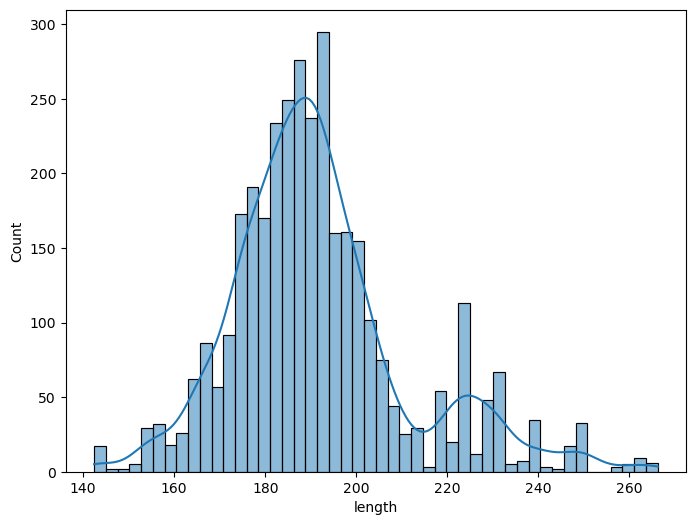

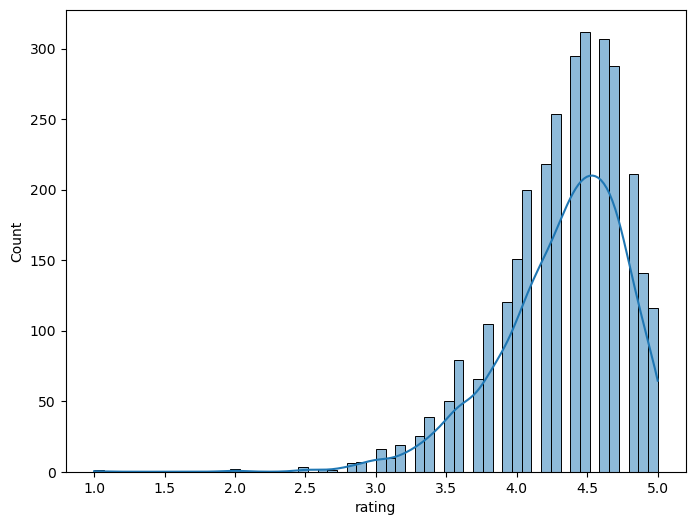

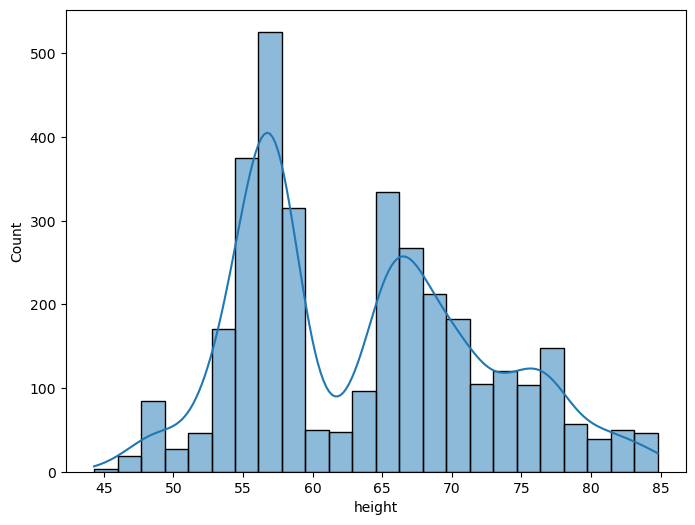

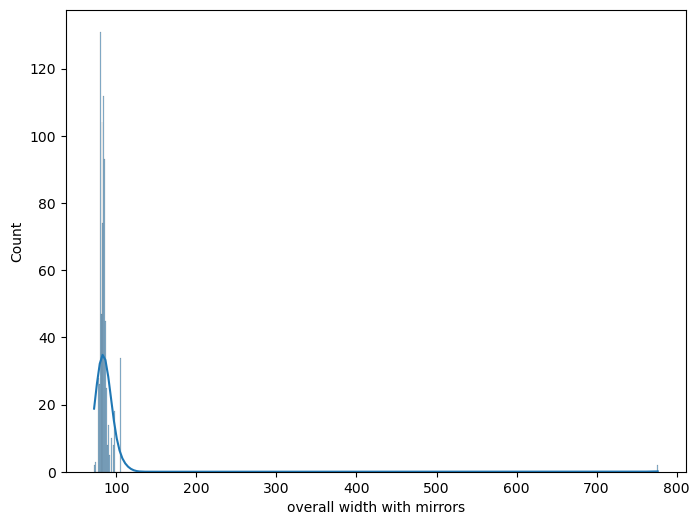

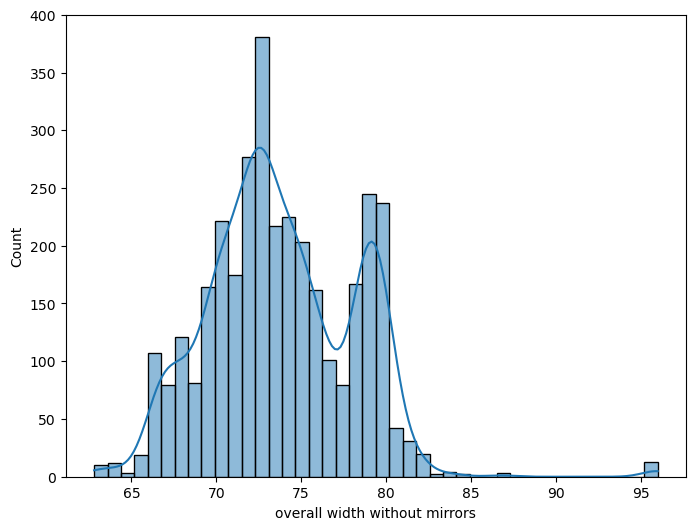

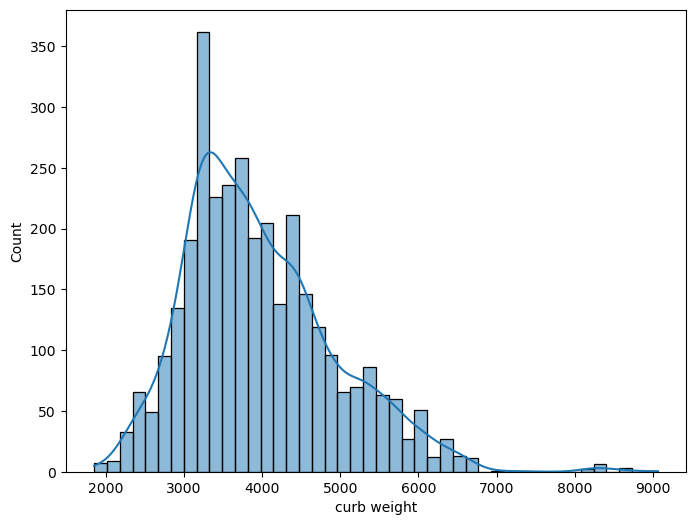

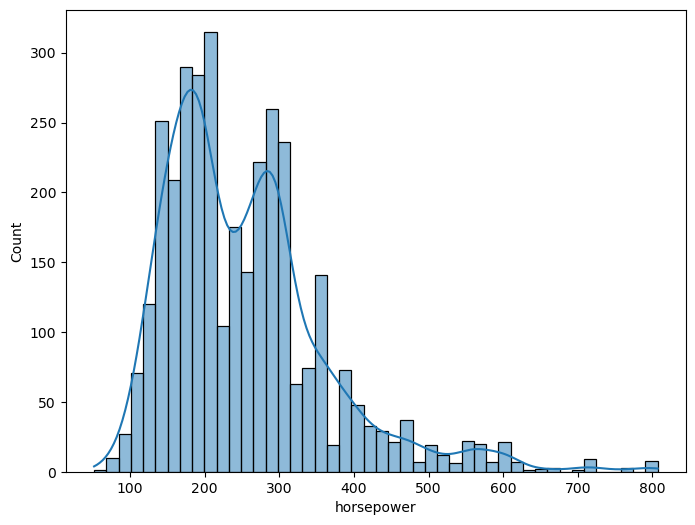

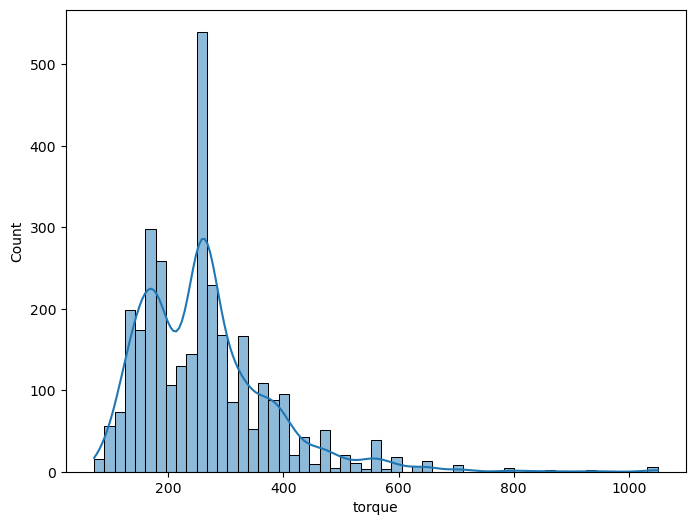

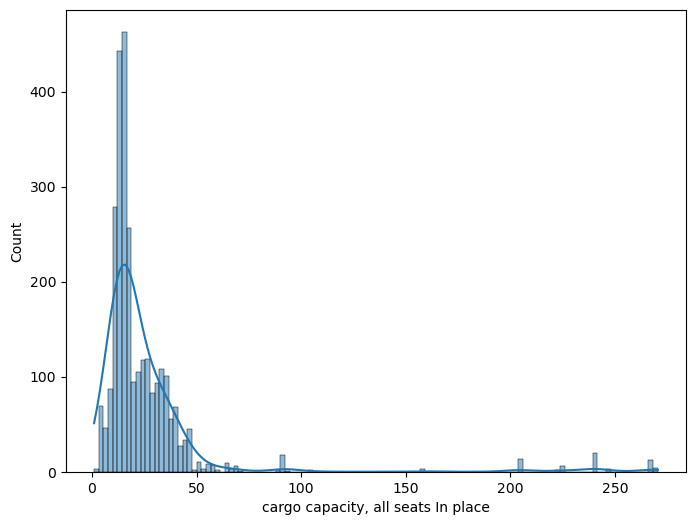

In [327]:

for col in cols_to_check:
  print(f"----------------------")
  print(f"Column: {col}")
  plt.figure(figsize=(8, 6))
  sns.histplot(df[col], kde=True)

  col_skew = df[col].skew()
  col_mean = df[col].mean()
  col_median = df[col].median()
  print(f"Rating Skew: {col_skew}")
  print(f"Rating Mean: {col_mean}")
  print(f"Rating Median: {col_median}")

In [328]:
for col in cols_to_check:
  median_value = df[col].median()
  df[col].fillna(median_value, inplace=True)

In [329]:
df['rating'] = df['rating'].apply(lambda x: 0 if x>=3.5 else 1)

<AxesSubplot:>

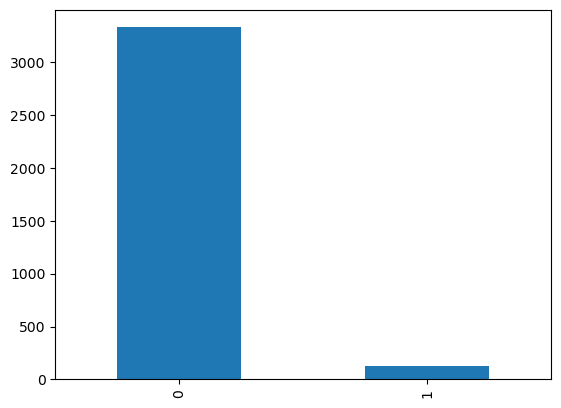

In [330]:
df["rating"].value_counts().plot.bar()

# Check Class Imbalance

Class=0, Count=3332, Percentage=96.217%
Class=1, Count=131, Percentage=3.783%


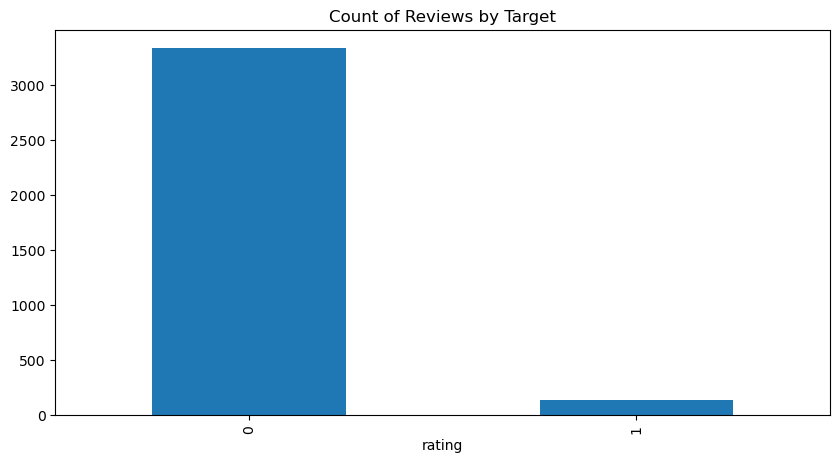

In [331]:
check_class_imbalance(df, df['rating'], "rating")

In [332]:
categorical_features, numeric_features = df.select_dtypes(include="object"), df.select_dtypes(include=["int64", "float64"]).drop("rating", axis=1)

# Separate Features

In [333]:
X, y = df.drop("rating", axis=1), df["rating"]

# Preprocessor Pipeline

In [334]:
preprocessor = create_column_transformer(numeric_features, categorical_features)

# Baseline Model Evaluation

In [335]:
model = DummyClassifier(strategy="constant",constant=1)
pipeline = create_pipeline(preprocessor, model)
scores = evaluate_model(X, y, pipeline)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.038, STD: 0.001


# Advanced Metrics

In [336]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
1,SVC,0.962749,0.000928
0,LR,0.962364,0.002074


In [337]:
names = ["RFC", "DTC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
0,RFC,0.963327,0.005420
1,DTC,0.952545,0.007638


In [338]:

names = ["GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
0,GBC,0.963327,0.004965
1,XGB,0.963133,0.004350


# Imbalanced Dataset will give us misleading accuracy scores

# Lets try some Oversampling techniques

In [339]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE", preprocessor)

In [340]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote, preprocessor, sampled=True)

,Model,Mean,STD
3,XGB,0.983193,0.002368
0,RFC,0.981943,0.004038
1,DTC,0.972539,0.004277
2,GBC,0.955683,0.006067


In [341]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote, preprocessor, sampled=True)

,Model,Mean,STD
1,SVC,0.944277,0.005168
0,LR,0.916266,0.004665


# Let's test some models on predictions and asses if these accuracy scores are actually robust

Validation Test accuracy for LR: 0.918
Test accuracy for LR: 0.912
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       517
           1       0.87      0.96      0.91       483

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



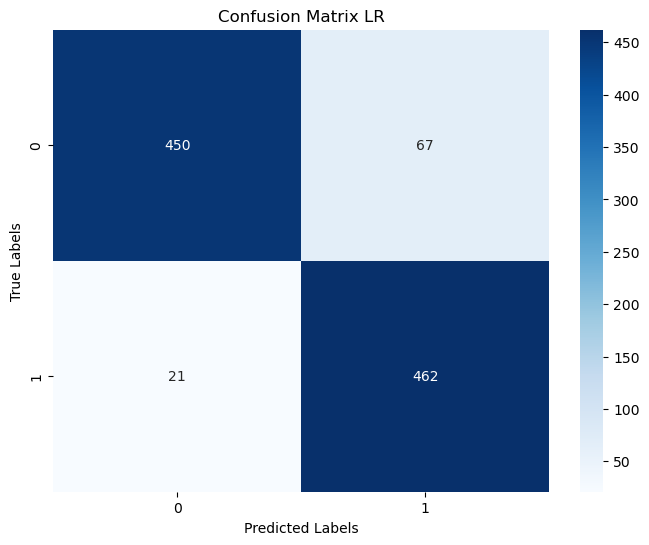

Validation Test accuracy for SVC: 0.946
Test accuracy for SVC: 0.935
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       517
           1       0.89      0.99      0.94       483

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.93      1000
weighted avg       0.94      0.94      0.93      1000



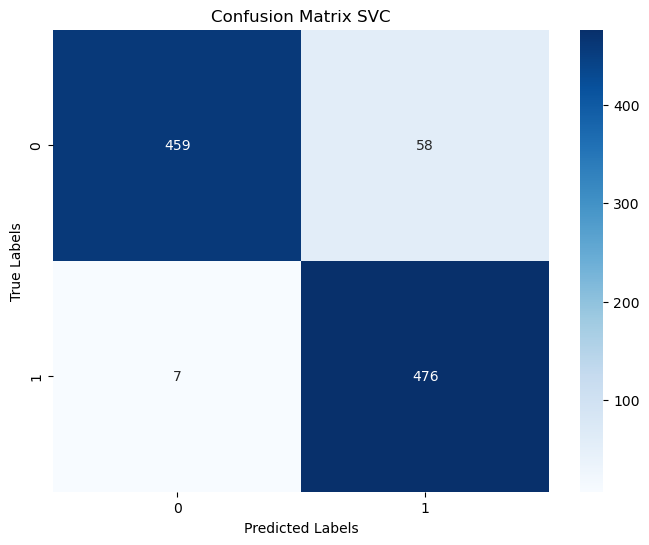

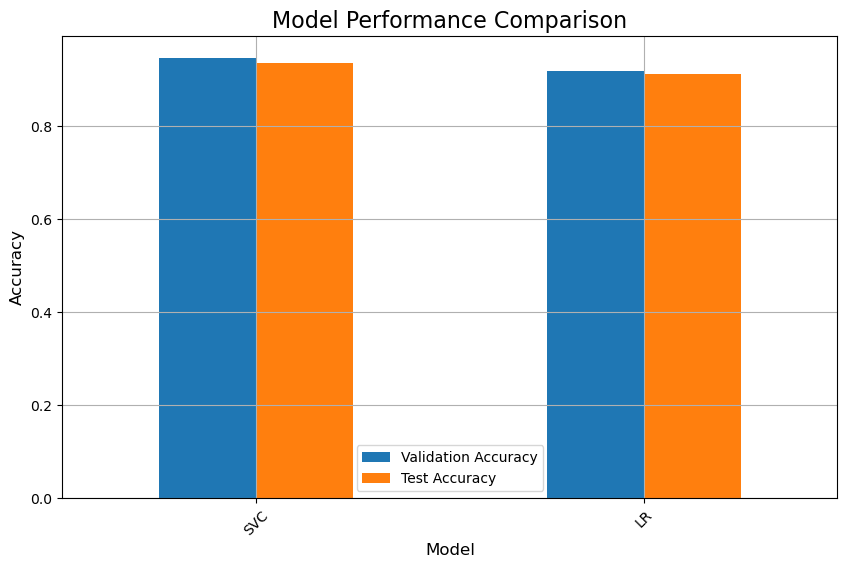

In [361]:
names = ['LR', 'SVC']
models = get_selected_models(names)
test_model_predictions(names, models, X_smote, y_smote)

Validation Test accuracy for RFC: 0.983
Test accuracy for RFC: 0.976
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       517
           1       0.97      0.98      0.98       483

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



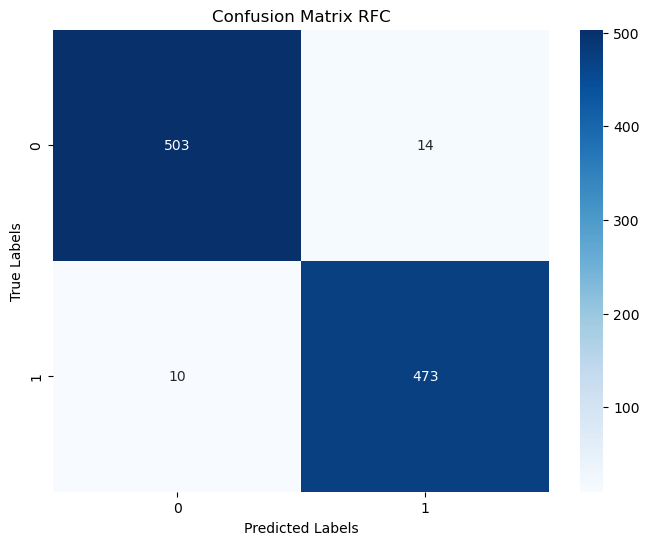

Validation Test accuracy for GBC: 0.966
Test accuracy for GBC: 0.956
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       517
           1       0.94      0.98      0.96       483

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



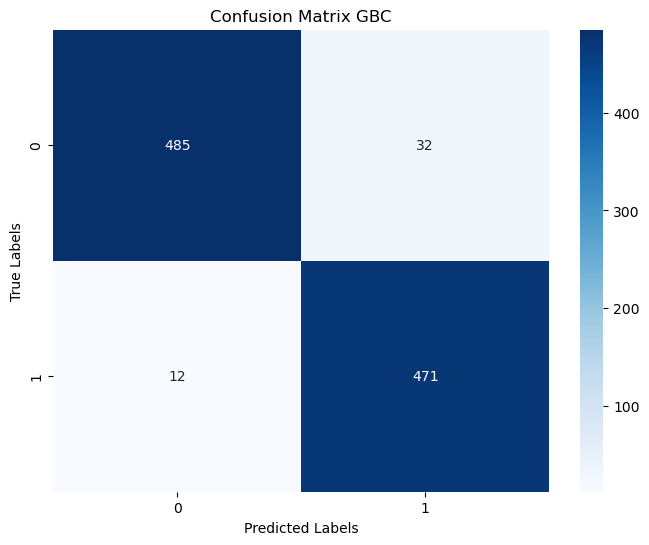

Validation Test accuracy for XGB: 0.989
Test accuracy for XGB: 0.984
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.98      0.98      0.98       483

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



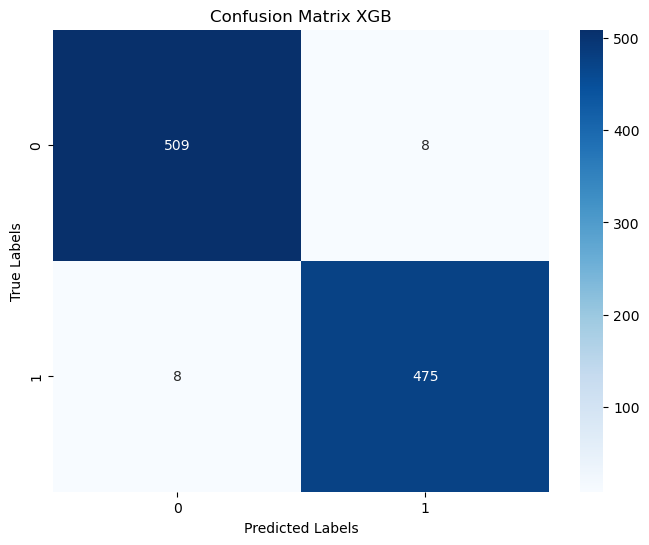

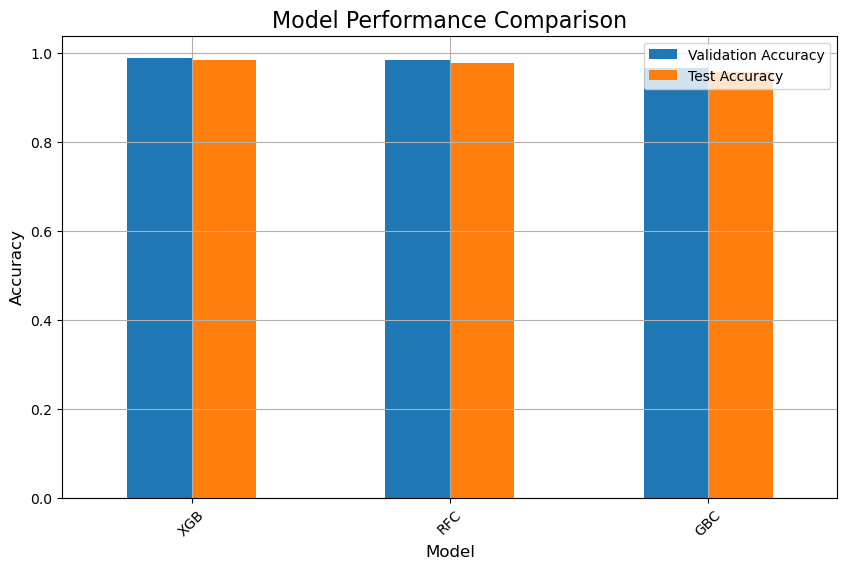

In [362]:
names = ['RFC', 'GBC', 'XGB']
models = get_selected_models(names)
metric = make_scorer(accuracy_score)
test_model_predictions(names, models, X_smote, y_smote)

# Validation accuracy is higher than the test accuracy which could signal model overfitting but they're extremely similar so it shows the model generalizes well to the test set.